<a href="https://colab.research.google.com/github/olivia-sp/embedded/blob/main/tt_forcasting_pytorchLSTM_v0_2_olivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install sktime

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
OUTPUT_HYNET_HSCITY_PATH = '/content/drive/MyDrive/Colab Notebooks/data_set/output_hynet_hscity.csv'
OUTPUT_HYNET_ICAPT2_PATH = '/content/drive/MyDrive/Colab Notebooks/data_set/output_hynet_icapt2.csv'

In [92]:
batch = 32
lag_length, horizon = 64, 2

In [169]:
import torch
from torch import nn, optim
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from tqdm import tqdm
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

# 데이터 불러오기
data_hscity = pd.read_csv(OUTPUT_HYNET_HSCITY_PATH)
data_icapt2 = pd.read_csv(OUTPUT_HYNET_ICAPT2_PATH)

preprocessing = 변수추가

In [170]:
# 일별, 시간별 압력량 평균 추가
pressure_mean = pd.pivot_table(data_hscity, values = 'tt_pressr', index = ['day_p', 'hour_p'], aggfunc = np.mean).reset_index()
tqdm.pandas()
data_hscity['day_hour_mean'] = data_hscity.progress_apply(lambda x : pressure_mean.loc[(pressure_mean.hour_p == x['hour_p']) & (pressure_mean.day_p == x['day_p']) ,'tt_pressr'].values[0], axis = 1)

100%|██████████| 39685/39685 [00:26<00:00, 1521.30it/s]


In [171]:
# 시간별 압력량 평균 추가
pressure_hour_mean = pd.pivot_table(data_hscity, values = 'tt_pressr', index = ['hour_p'], aggfunc = np.mean).reset_index()
tqdm.pandas()
data_hscity['hour_mean'] = data_hscity.progress_apply(lambda x : pressure_hour_mean.loc[(pressure_hour_mean.hour_p == x['hour_p']) ,'tt_pressr'].values[0], axis = 1)

# 시간별 압력량 표준편차 추가
pressure_hour_std = pd.pivot_table(data_hscity, values = 'tt_pressr', index = ['hour_p'], aggfunc = np.std).reset_index()
tqdm.pandas()
data_hscity['hour_std'] = data_hscity.progress_apply(lambda x : pressure_hour_std.loc[(pressure_hour_std.hour_p == x['hour_p']) ,'tt_pressr'].values[0], axis = 1)

100%|██████████| 39685/39685 [00:13<00:00, 2892.67it/s]


In [173]:
data_hscity.head()

,last_mdfcn_dt,tt_pressr,wait_vhcle_alge,year_p,month_p,day_p,hour_p,chrgr_ty_nm,ntsl_pc,4159020121HS2021012,...,oper_open,chrstn_single,spldmd_tt,Single Dispenser,car,card,rsvt_No,day_hour_mean,hour_mean,hour_std
0,2022-08-25 11:32:24,470,0,2022,8,25,11,700,8800.0,1,...,0,1,1,1,1,1,1,940.943396,1112.114216,357.920236
1,2022-08-25 11:37:24,470,0,2022,8,25,11,700,8800.0,1,...,0,1,1,1,1,1,1,940.943396,1112.114216,357.920236
2,2022-08-25 11:42:24,470,0,2022,8,25,11,700,8800.0,1,...,0,1,1,1,1,1,1,940.943396,1112.114216,357.920236
3,2022-08-25 11:47:24,470,0,2022,8,25,11,700,8800.0,1,...,0,1,1,1,1,1,1,940.943396,1112.114216,357.920236
4,2022-08-25 11:52:24,470,0,2022,8,25,11,700,8800.0,1,...,0,1,1,1,1,1,1,940.943396,1112.114216,357.920236


In [185]:
d1_hscity = data_hscity.drop(['last_mdfcn_dt'], axis=1)
#d1_hscity = d1_hscity.drop(['hour_std'], axis=1)

In [186]:
# Split data -- train:test == 8:2
train_cutoff = int(len(d1_hscity) * 0.8)
train_data, test_data = d1_hscity[:train_cutoff], d1_hscity[train_cutoff:]

In [ ]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_data.iloc[:, :-1])

train_data.iloc[:, :-1] = scaler_x.transform(train_data.iloc[:, :-1])
test_data.iloc[:, :-1] = scaler_x.transform(test_data.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_data.iloc[:, [0]])

train_data.iloc[:, -1] = scaler_y.transform(train_data.iloc[:, [0]])
test_data.iloc[:, -1] = scaler_y.transform(test_data.iloc[:, [0]])

In [199]:
train_data

,tt_pressr,wait_vhcle_alge,year_p,month_p,day_p,hour_p,chrgr_ty_nm,ntsl_pc,4159020121HS2021012,cnf_normal,...,oper_open,chrstn_single,spldmd_tt,Single Dispenser,car,card,rsvt_No,day_hour_mean,hour_mean,hour_std
0,0.246073,0.0,0.0,0.0,0.800000,0.478261,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244332,0.602730,0.246073
1,0.246073,0.0,0.0,0.0,0.800000,0.478261,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244332,0.602730,0.246073
2,0.246073,0.0,0.0,0.0,0.800000,0.478261,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244332,0.602730,0.246073
3,0.246073,0.0,0.0,0.0,0.800000,0.478261,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244332,0.602730,0.246073
4,0.246073,0.0,0.0,0.0,0.800000,0.478261,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244332,0.602730,0.246073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31743,0.523560,0.0,0.0,1.0,0.433333,0.260870,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297776,0.007723,0.523560
31744,0.523560,0.0,0.0,1.0,0.433333,0.260870,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297776,0.007723,0.523560
31745,0.523560,0.0,0.0,1.0,0.433333,0.304348,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294144,0.118482,0.523560
31746,0.523560,0.0,0.0,1.0,0.433333,0.304348,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294144,0.118482,0.523560


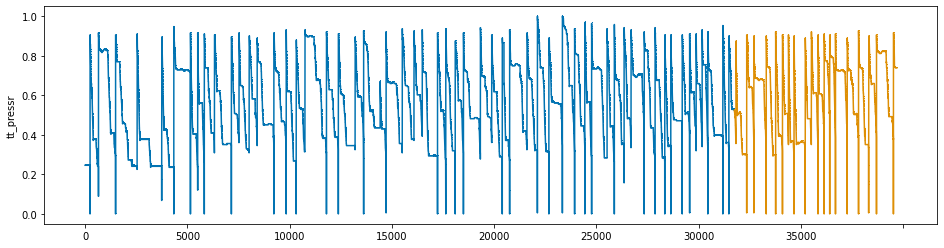

In [203]:
plot_series(train_data['tt_pressr'], test_data['tt_pressr'], markers=[',' , ','])
plt.show()

#LSTM

- 파이토치에서는 3D 텐서의 입력을 받으므로 torch.FloatTensor를 사용하여 np.arrary 형태에서 tensor로 변환
- Dataset을 정의하고 이를 DataLoader에 전달하는 것

In [204]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [205]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, 1:]
        _y = time_series[i+seq_length, [0]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

#trainX, trainY = build_dataset(np.array(train_data), lag_length+horizon)
#testX, testY = build_dataset(np.array(test_data), lag_length+horizon)

trainX, trainY = build_dataset(np.array(train_data), lag_length)
testX, testY = build_dataset(np.array(test_data), lag_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [207]:
# 설정값
data_dim = 21
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 100

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [208]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    #criterion = nn.MSELoss().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [209]:
# 모델 학습
#net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
net = Net(data_dim, hidden_dim, lag_length, output_dim, 1)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.0036
Epoch: 0020 train loss : 0.0005
Epoch: 0040 train loss : 0.0004
Epoch: 0060 train loss : 0.0005

 Early Stopping


In [210]:
print(model)

Net(
  (lstm): LSTM(21, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


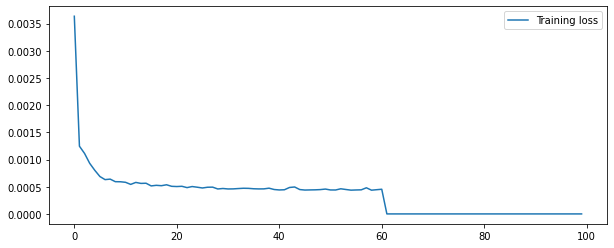

In [211]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

- pythorch는 .pt 또는 .pth 파일 확장자로 모델을 저장
- torch 사용하여 모델의 state_dict을 저장하는 것이 권장하는 방법

- 모델을 불러 온 후에는 반드시 model.eval() 를 호출하여 드롭아웃 및 배치 정규화를 평가모드로 설정
- 평가모드를 사용하지 않고 테스트를 하게 되면 추론 결과가 일관성없게 추론됨

In [212]:
# 모델 저장    
PATH = "./TT_LSTM.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
#model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model = Net(data_dim, hidden_dim, lag_length, output_dim, 1)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(21, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

- torch.no_grad() : gradient 계산을 수행하지 않게 되어 메모리 사용량 절약
- 예측시에도 새로운 seq가 입력될 때마다 hidden_state를 초기화해야 이전 seq의 영향을 받지 않음

In [213]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def MSE(true, pred):
  # cost 계산
    return np.square(np.subtract(true, pred)).mean()

print('MAE SCORE : ', MAE(testY_inverse, pred_inverse))
print('MSE SCORE : ', MSE(testY_inverse, pred_inverse))

MAE SCORE :  0.031895846075586674
MSE SCORE :  0.006684269063216535


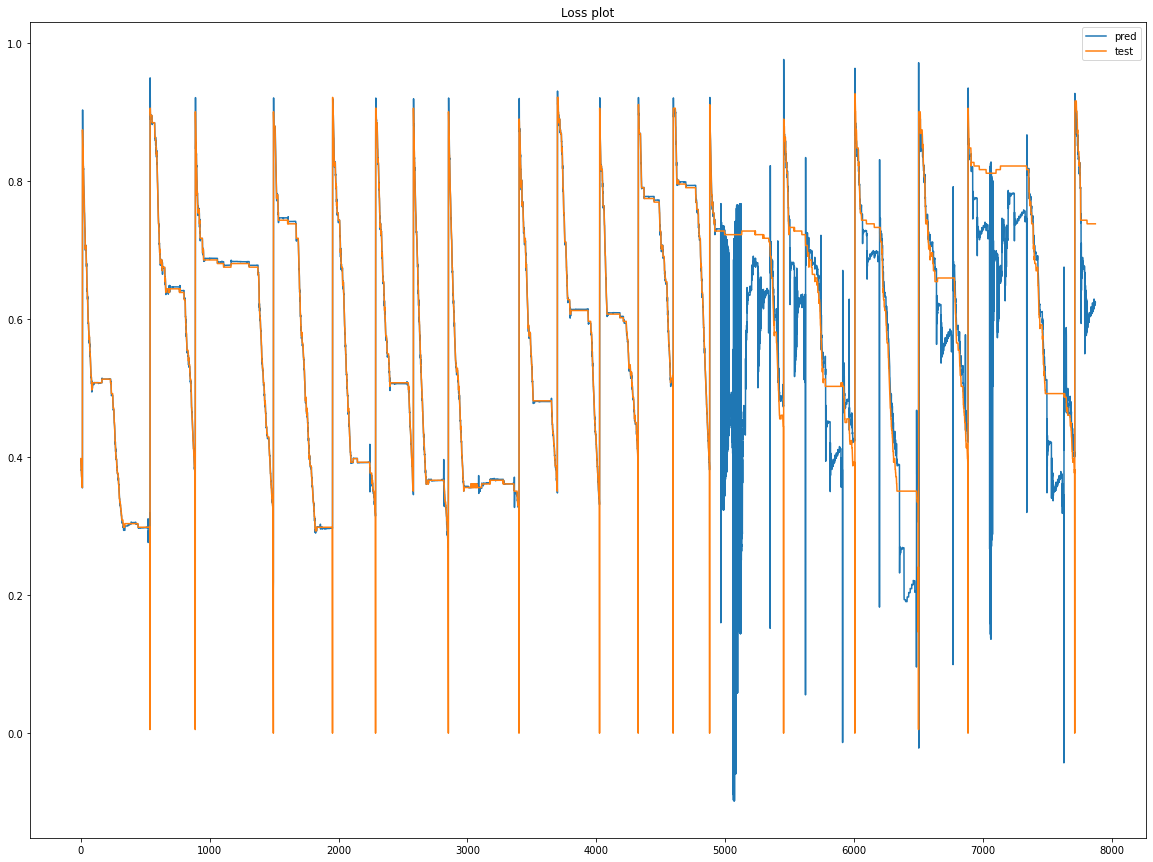

In [214]:
fig = plt.figure(figsize=(20,15))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'test')
plt.title("Loss plot")
plt.legend(['pred', 'test'], loc='upper right')
plt.show()

* 예측값 후처리

In [215]:
#예측값(tt) 음수인 경우 이전 값으로 대체
for i in range (len(pred_inverse)):
  if pred_inverse[i] < 0:
    #print(pred_inverse[i])
    pred_inverse[i] = pred_inverse[i-1]

In [216]:
print('MAE SCORE : ', MAE(testY_inverse, pred_inverse))
print('MSE SCORE : ', MSE(testY_inverse, pred_inverse))

MAE SCORE :  0.030549160675398243
MSE SCORE :  0.0055533014531162226


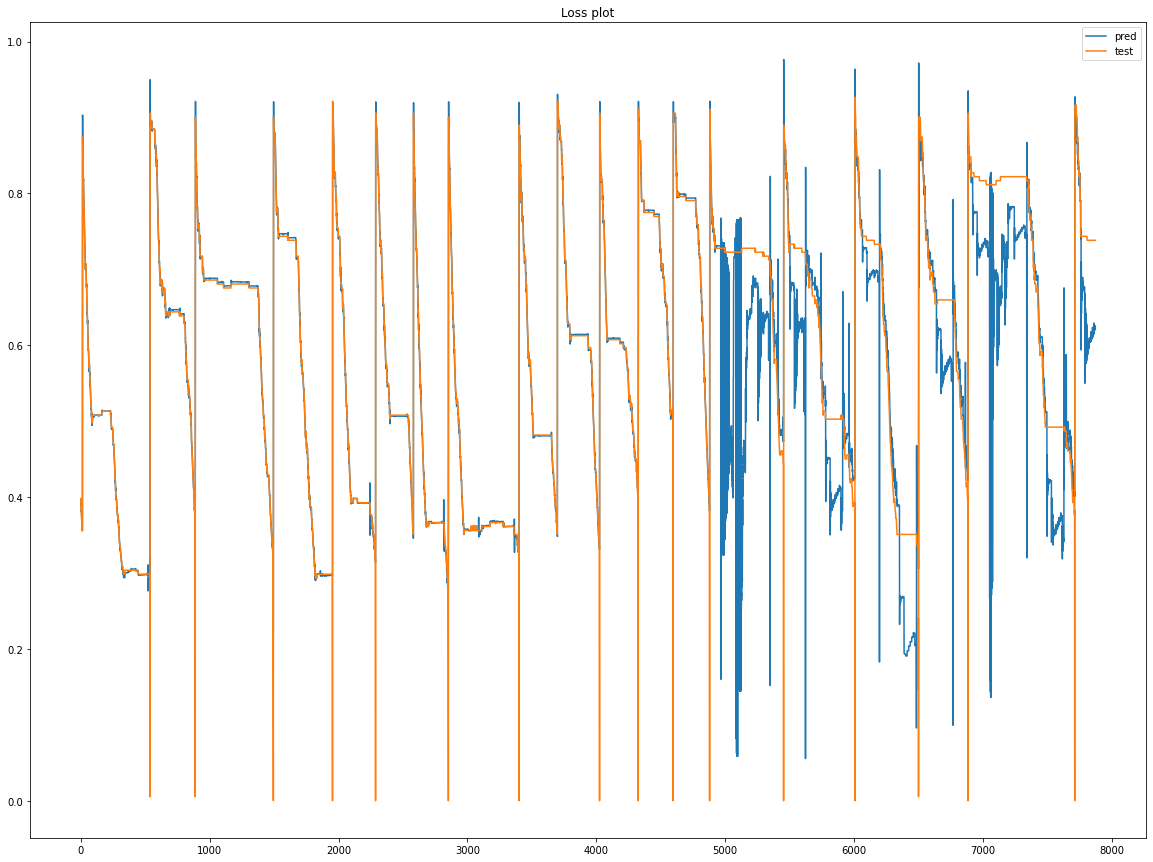

In [217]:
fig = plt.figure(figsize=(20,15))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'test')
plt.title("Loss plot")
plt.legend(['pred', 'test'], loc='upper right')
plt.show()

##LSTM2